<a href="https://colab.research.google.com/github/tiitvaino/NAI22_hand_drawn_sketches/blob/main/Simple_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/tiitvaino/NAI22_hand_drawn_sketches.git -q

In [1]:
import json
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.display import display
import cv2

import warnings
warnings.filterwarnings('ignore')

In [62]:
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
def read_class_sketches(path:str,class_name:str)->pd.DataFrame:
  norm_imgs = np.load(f'{path}/norm_imgs/{class_name}.npy',allow_pickle=True)
  recs = np.load(f'{path}/recognized/{class_name}.npy',allow_pickle=True)
  preprocessed_df = pd.DataFrame({'recognized':recs,'norm_image':norm_imgs})
  return preprocessed_df

def read_all_classes(path:str='.')->pd.DataFrame:
  classes = np.load(f'{path}/processed_classes.npy')
  df_list = []
  for class_name in classes:
    preprocessed_df = read_class_sketches(path,class_name)
    preprocessed_df['word'] = class_name
    df_list.append(preprocessed_df)
  
  pre_df = pd.concat(df_list)
  pre_df['onehot'] = pre_df.word.str.get_dummies().values.tolist()

  return pre_df,classes

In [4]:
pre_df, classes = read_all_classes('NAI22_hand_drawn_sketches')

In [12]:
pre_df

,recognized,norm_image,word,onehot
0,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",aircraft carrier,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",aircraft carrier,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",aircraft carrier,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",aircraft carrier,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",aircraft carrier,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
995,True,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",arm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
996,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",arm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
997,True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",arm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
998,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",arm,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [77]:
norm_image = pre_df.norm_image
onehot = pre_df.onehot

X = []
for img in norm_image:
  X.append(img)

y = []
for i in onehot:
  y.append(i)

X = np.asarray(X)
y = np.asarray(y)

X = X.reshape(X.shape[0], 100, 100, 1).astype('float32')

In [78]:
print(X.shape)
print(y.shape)

(10000, 100, 100, 1)
(10000, 10)


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
X_train.shape[1:]

(100, 100)

In [131]:
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=X_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 

adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)      

In [132]:
model.fit(X_train, y_train, validation_split = 0.1, batch_size = 64, epochs=5)

Epoch 1/5
113/113 [==============================] - 71s 619ms/step - loss: 1.4462 - top_k_categorical_accuracy: 0.8757 - val_loss: 0.8802 - val_top_k_categorical_accuracy: 0.9700
Epoch 2/5
113/113 [==============================] - 76s 674ms/step - loss: 0.7198 - top_k_categorical_accuracy: 0.9793 - val_loss: 0.6529 - val_top_k_categorical_accuracy: 0.9900
Epoch 3/5
113/113 [==============================] - 66s 588ms/step - loss: 0.5057 - top_k_categorical_accuracy: 0.9893 - val_loss: 0.4767 - val_top_k_categorical_accuracy: 0.9875
Epoch 4/5
113/113 [==============================] - 66s 587ms/step - loss: 0.3949 - top_k_categorical_accuracy: 0.9935 - val_loss: 0.4485 - val_top_k_categorical_accuracy: 0.9937
Epoch 5/5
113/113 [==============================] - 67s 597ms/step - loss: 0.3106 - top_k_categorical_accuracy: 0.9967 - val_loss: 0.3929 - val_top_k_categorical_accuracy: 0.9937


In [133]:
score = model.evaluate(X_test, y_test)
print(f'Test accuarcy: {score[1] * 100:.2f}%')

63/63 [==============================] - 5s 86ms/step - loss: 0.4601 - top_k_categorical_accuracy: 0.9900
Test accuarcy: 99.00%


In [134]:
pred = model.predict(X_test)

63/63 [==============================] - 5s 84ms/step


In [135]:
pred_classes = np.argmax(pred, axis=1)
actual_classes = np.argmax(y_test, axis=1)
acc = np.sum(pred_classes == actual_classes)/len(y_test)
print(f'Classification accuarcy: {acc * 100:.2f}%')

Classification accuarcy: 85.45%


In [136]:
def score_scetch(i):
  plt.imshow(X_test[i].reshape(100, 100))
  plt.show()
  print(f'Actual class: {classes[y_test[i] == 1][0]}')
  print(f'Predicted class: {classes[np.argmax(pred[i])]}')
  print(f'Score by model: {pred[i][y_test[i] == 1][0]:.3f}')

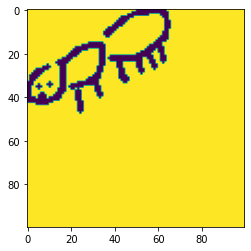

Actual class: ant
Predicted class: ant
Score by model: 0.988


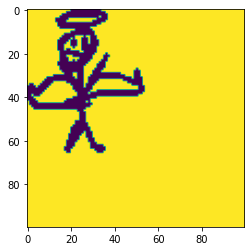

Actual class: angel
Predicted class: angel
Score by model: 0.991


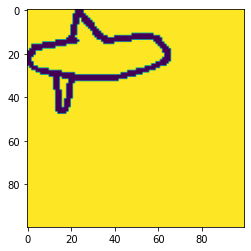

Actual class: airplane
Predicted class: aircraft carrier
Score by model: 0.230


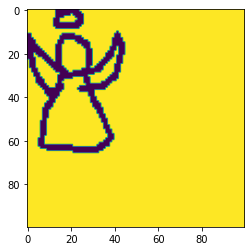

Actual class: angel
Predicted class: angel
Score by model: 0.984


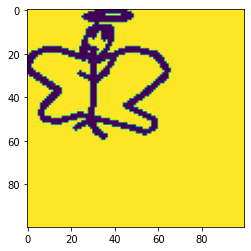

Actual class: angel
Predicted class: angel
Score by model: 0.999


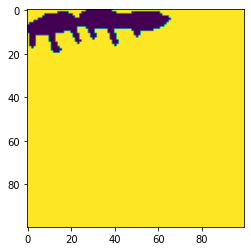

Actual class: ant
Predicted class: animal migration
Score by model: 0.027


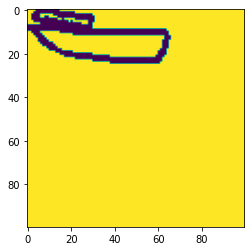

Actual class: aircraft carrier
Predicted class: aircraft carrier
Score by model: 0.945


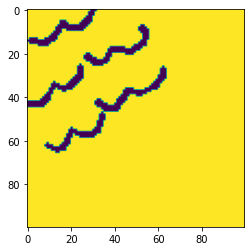

Actual class: animal migration
Predicted class: animal migration
Score by model: 0.983


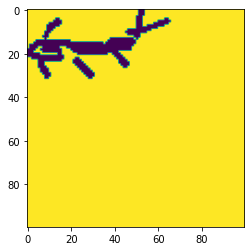

Actual class: ant
Predicted class: ant
Score by model: 0.647


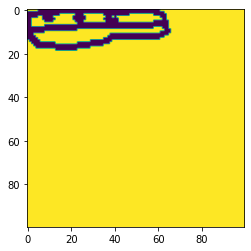

Actual class: aircraft carrier
Predicted class: aircraft carrier
Score by model: 0.945


In [137]:
for i in range(10):
  score_scetch(i)